In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### 载入数据集

In [2]:
def load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

In [3]:
train_X, train_Y = load_dataset()

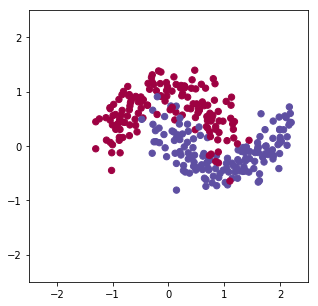

In [4]:
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.scatter(train_X[0, :], train_X[1, :], c=train_Y[0], s=40, cmap=plt.cm.Spectral);

### Z-score标准化输入

In [5]:
train_X_mean = train_X.mean(axis=1).reshape(train_X.shape[0], 1)
train_X_std = train_X.std(axis=1).reshape(train_X.shape[0], 1)
train_X = (train_X - train_X_mean) / train_X_std

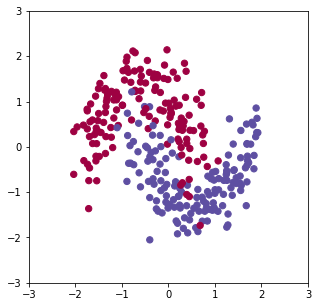

In [6]:
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.scatter(train_X[0, :], train_X[1, :], c=train_Y[0], s=40, cmap=plt.cm.Spectral);

### 深层神经网络（隐藏层ReLU 输出层sigmoid）

In [7]:
# sigmoid激活函数
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

# ReLU激活函数
def relu(Z):
    return np.maximum(0, Z)

In [8]:
# 初始化深层神经网络的参数 使用HE初始化
def initialize_parameters_he(layers_dims, lambd = 1):
    parameters = {}
    
    # 深层神经网络的层数（包含0层）
    L = len(layers_dims)
    
    # 初始化 W b
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * np.sqrt(lambd * 2 / layers_dims[l - 1]) # HE初始化
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

In [9]:
# 计算正向传播 ReLU->ReLU->...->Sigmoid
def forward_propagate(parameters, X):
    L = len(parameters) // 2
    
    caches = {}
    
    A = X
    caches['A0'] = A
    for l in range(1, L):
        Z = parameters['W' + str(l)] @ A + parameters['b' + str(l)]
        A = relu(Z)
        caches['A' + str(l)] = A
    
    Z = parameters['W' + str(L)] @ A + parameters['b' + str(L)]
    A = sigmoid(Z)
    caches['A' + str(L)] = A
    
    return A, caches

In [10]:
# 计算损失函数 cross-entropy cost
def compute_cost(AL, Y):
    logprobs = Y * np.log(AL) + (1 - Y) * np.log(1 - AL) # 可能会出现log(0)的情况，此时log(0)=-inf，不影响反向传播计算
    cost = -np.nanmean(logprobs) # 过滤掉出现-inf的数据
    return cost

In [11]:
# 计算反向传播 Sigmoid->ReLU->...->ReLU
def backward_propagate(parameters, Y, caches):
    L = len(parameters) // 2
    
    grads = {}
    
    dZ = caches['A' + str(L)] - Y # cross-entropy cost对AL的偏导数 * sigmoid的导数
    grads['dW' + str(L)] = dZ @ caches['A' + str(L - 1)].T / dZ.shape[1]
    grads['db' + str(L)] = np.mean(dZ, axis=1, keepdims=True)
    
    for l in reversed(range(1, L)):
        dZ =  parameters['W' + str(l + 1)].T @ dZ * (caches['A' + str(l)] > 0) # ReLU的导数
        grads['dW' + str(l)] = dZ @ caches['A' + str(l - 1)].T / dZ.shape[1]
        grads['db' + str(l)] = np.mean(dZ, axis=1, keepdims=True)
    
    return grads

In [12]:
# 对样本进行预测
def predict(parameters, X):
    AL, caches = forward_propagate(parameters, X)
    AL = AL > 0.5
    return AL.astype(np.int)

In [13]:
# 计算准确率
def compute_accuracy(parameters, X, Y):
    P = predict(parameters, X)
    return float((Y @ P.T + (1 - Y) @ (1 - P.T)) / float(Y.size))

In [14]:
# 绘制决策边界图
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

### 使用Adam优化算法进行梯度下降

In [15]:
# Adam梯度下降法初始化
def initialize_adam(parameters):
    L = len(parameters) // 2
    
    v = {}
    s = {}
    
    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros(parameters['W' + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters['b' + str(l)].shape)
        s["dW" + str(l)] = np.zeros(parameters['W' + str(l)].shape)
        s["db" + str(l)] = np.zeros(parameters['b' + str(l)].shape)
    
    return v, s

# 用Adam梯度下降法更新参数
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}
    
    for l in range(1, L + 1):
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads["dW" + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads["db" + str(l)]
        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - beta1**t)
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - beta1**t)
        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * grads["dW" + str(l)]**2
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * grads["db" + str(l)]**2
        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - beta2**t)
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - beta2**t)
        parameters['W' + str(l)] -= learning_rate * v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon)
        parameters['b' + str(l)] -= learning_rate * v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon)
    
    return parameters, v, s

### Mini-batch Adam梯度下降

In [16]:
# 将数据集随机打乱并分块
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    assert(X.shape[1] == Y.shape[1])
    assert(Y.shape[0] == 1)
    
    if seed > 0:
        np.random.seed(seed)
    
    m = X.shape[1] # 样本数量
    mini_batches = []
    
    # 打乱(X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    # 分块(shuffled_X, shuffled_Y) 除尾部外
    num_complete_minibatches = math.floor(m / mini_batch_size) # 完整的mini batches数量
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, mini_batch_size * k : mini_batch_size * (k + 1)]
        mini_batch_Y = shuffled_Y[:, mini_batch_size * k : mini_batch_size * (k + 1)]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # 处理尾部
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, mini_batch_size * num_complete_minibatches : ]
        mini_batch_Y = shuffled_Y[:, mini_batch_size * num_complete_minibatches : ]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [17]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0007, decay_rate = 0.001, mini_batch_size = 64, 
                  beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, num_epochs = 10000, print_cost = False):
    costs = [] # 损失函数记录
    t = 0 # Adam梯度下降调用次数
    
    # 初始化参数 W1 b1 ... WL bL
    parameters = initialize_parameters_he(layers_dims)
    
    # Adam梯度下降法初始化
    v, s = initialize_adam(parameters)
    
    # 梯度下降法循环迭代
    for i in range(num_epochs):
        # 每个新的epoch开始都将数据集重新打乱并分块
        minibatches = random_mini_batches(X, Y, mini_batch_size)
        
        # 遍历每个数据分块
        for minibatch in minibatches:
            minibatch_X, minibatch_Y = minibatch
            AL, caches = forward_propagate(parameters, minibatch_X)
            grads = backward_propagate(parameters, minibatch_Y, caches)
            t += 1
            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, 
                                                           learning_rate / (1 + decay_rate * i), beta1, beta2, epsilon)
        
        # 记录并打印cost
        if print_cost:
            if i % 100 == 0:
                cost = compute_cost(AL, minibatch_Y)
                costs.append(cost)
                if i % 1000 == 0:
                    print("Cost after epoch %i: %f" %(i, cost))
    
    # 绘制损失函数
    if print_cost:
        plt.figure(figsize=(7.0, 4.0))
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('epochs (per 100)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

### Mini-batch Gradient descent with Adam mode

In [18]:
# 设定深层神经网络层数和各层节点数 共3层
layers_dims = [train_X.shape[0], 5, 2, 1]

Cost after epoch 0: 0.682390
Cost after epoch 1000: 0.196941
Cost after epoch 2000: 0.239073
Cost after epoch 3000: 0.129017
Cost after epoch 4000: 0.110836
Cost after epoch 5000: 0.126398
Cost after epoch 6000: 0.087958
Cost after epoch 7000: 0.233054
Cost after epoch 8000: 0.155834
Cost after epoch 9000: 0.098307


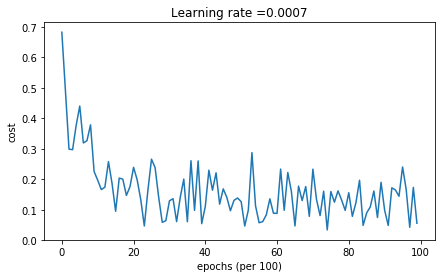

In [19]:
# 训练深层神经网络模型
parameters = L_layer_model(train_X, train_Y, layers_dims, print_cost = True)

In [20]:
# 打印训练集和测试集的准确率
print('训练集准确率: %d' % float(compute_accuracy(parameters, train_X, train_Y) * 100) + '%')

训练集准确率: 93%


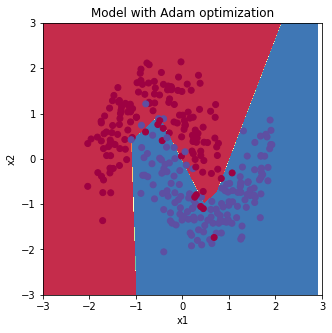

In [21]:
# 绘制决策边界图
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-3, 3])
axes.set_ylim([-3, 3])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y[0])